In [1]:
# saves you having to use print as all exposed variables are printed in the cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
# suppress warning message
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pyarrow as pa
import pyarrow.compute as pc
from nn_rag import Knowledge
from tqdm import tqdm

## Discovery
### Instantiate the capability

In [4]:
kn = Knowledge.from_memory()

### Build the table

In [5]:
text = ('Human Nutrition: 2020 Edition by University of Hawai‘i at Mānoa Food Science and Human Nutrition Program '
        'is licensed under a Creative Commons Attribution 4.0 International License, except where otherwise noted.\n\n'
        'This work was carried out with the aid of a grant from the International Development Research Centre, '
        'Ottawa, Canada, funded in part by the Government of Canada, and an additional grant from USAID.\n\n'
        'You took too long. You are not easy to deal with. Payment Failure/Incorrect Payment. You provided '
        'me with incorrect information. Unhappy with delay. Unsuitable advice. You never answered my question.\n\n'
        'You did not understand my needs. (1) I have been mis-sold. (2) My details are not accurate. You have asked '
        'for too much information. (3) You were not helpful. Payment not generated/received by customer. You did '
        'not keep me updated. Incorrect information given. (4) The performance of my product was poor.\n\n No reply '
        'to customer contact. Requested documentation not issued. You did not explain the terms & conditions.\n\n'
        'Policy amendments not carried out. You did not explain the next steps/process to me. I cannot '
        'understand your letter/comms. Standard letter inappropriate. Customer payment processed incorrectly.\n\n'
        'All points not addressed. Could not understand the agent. Issue with terms and conditions. Misleading '
        'information. I can not use the customer portal. your customer portal is unhelpful.')
full_text = [
    {"index": 1,
     "text_char_count": len(text),
     "text_token_count": round(len(text) / 4),
     "text": text}
]
tbl =  pa.Table.from_pylist(full_text)

### Discover the text

In [6]:
kn.table_report(tbl)

,index,text_char_count,text_token_count,text
0,1,1410,352,"Human Nutrition: 2020 Edition by University of Hawai‘i at Mānoa Food Science and Human Nutrition Program is licensed under a Creative Commons Attribution 4.0 International License, except where otherwise noted. This work was carried out with the aid of a grant from the International Development Research Centre, Ottawa, Canada, funded in part by the Government of Canada, and an additional grant from USAID. You took too long. You are not easy to deal with. Payment Failure/Incorrect Payment. You provided me with incorrect information. Unhappy with delay. Unsuitable advice. You never answered my question. You did not understand my needs. (1) I have been mis-sold. (2) My details are not accurate. You have asked for too much information. (3) You were not helpful. Payment not generated/received by customer. You did not keep me updated. Incorrect information given. (4) The performance of my product was poor. No reply to customer contact. Requested documentation not issued. You did not explain the terms & conditions. Policy amendments not carried out. You did not explain the next steps/process to me. I cannot understand your letter/comms. Standard letter inappropriate. Customer payment processed incorrectly. All points not addressed. Could not understand the agent. Issue with terms and conditions. Misleading information. I can not use the customer portal. your customer portal is unhelpful."


### Break the text into paragraphs

In [7]:
paragraphs = kn.tools.text_to_paragraphs(tbl)
kn.table_report(paragraphs)

building paragraphs:   0%|          | 0/277 [00:00<?, ?it/s]

,index,char_count,word_count,sentence_count,token_count,score,text
0,0,210,30,1,52,0,"Human Nutrition: 2020 Edition by University of Hawai‘i at Mānoa Food Science and Human Nutrition Program is licensed under a Creative Commons Attribution 4.0 International License, except where otherwise noted."
1,1,197,33,1,49,0,"This work was carried out with the aid of a grant from the International Development Research Centre, Ottawa, Canada, funded in part by the Government of Canada, and an additional grant from USAID."
2,2,199,30,7,50,0,You took too long. You are not easy to deal with. Payment Failure/Incorrect Payment. You provided me with incorrect information. Unhappy with delay. Unsuitable advice. You never answered my question.
3,3,416,70,12,104,0,You did not understand my needs. (1) I have been mis-sold. (2) My details are not accurate. You have asked for too much information. (3) You were not helpful. Payment not generated/received by customer. You did not keep me updated. Incorrect information given. (4) The performance of my product was poor. No reply to customer contact. Requested documentation not issued. You did not explain the terms & conditions.
4,4,194,26,5,48,0,Policy amendments not carried out. You did not explain the next steps/process to me. I cannot understand your letter/comms. Standard letter inappropriate. Customer payment processed incorrectly.
5,5,184,28,6,46,0,All points not addressed. Could not understand the agent. Issue with terms and conditions. Misleading information. I can not use the customer portal. your customer portal is unhelpful.


### Filter out the first two paragraphs

In [8]:
paragraphs = kn.tools.filter_on_mask(paragraphs, indices=[0,1])
kn.table_report(paragraphs)

,index,char_count,word_count,sentence_count,token_count,score,text
0,0,199,30,7,50,0,You took too long. You are not easy to deal with. Payment Failure/Incorrect Payment. You provided me with incorrect information. Unhappy with delay. Unsuitable advice. You never answered my question.
1,1,416,70,12,104,0,You did not understand my needs. (1) I have been mis-sold. (2) My details are not accurate. You have asked for too much information. (3) You were not helpful. Payment not generated/received by customer. You did not keep me updated. Incorrect information given. (4) The performance of my product was poor. No reply to customer contact. Requested documentation not issued. You did not explain the terms & conditions.
2,2,194,26,5,48,0,Policy amendments not carried out. You did not explain the next steps/process to me. I cannot understand your letter/comms. Standard letter inappropriate. Customer payment processed incorrectly.
3,3,184,28,6,46,0,All points not addressed. Could not understand the agent. Issue with terms and conditions. Misleading information. I can not use the customer portal. your customer portal is unhelpful.


### Reconstruct back to a document

In [9]:
doc = kn.tools.text_to_document(paragraphs, sep='\n\n')
print(doc['text'].to_pylist())

['You took too long. You are not easy to deal with. Payment Failure/Incorrect Payment. You provided me with incorrect information. Unhappy with delay. Unsuitable advice. You never answered my question.\n\nYou did not understand my needs. (1) I have been mis-sold. (2) My details are not accurate. You have asked for too much information. (3) You were not helpful. Payment not generated/received by customer. You did not keep me updated. Incorrect information given. (4) The performance of my product was poor.   No reply to customer contact. Requested documentation not issued. You did not explain the terms & conditions.\n\nPolicy amendments not carried out. You did not explain the next steps/process to me. I cannot understand your letter/comms. Standard letter inappropriate. Customer payment processed incorrectly.\n\nAll points not addressed. Could not understand the agent. Issue with terms and conditions. Misleading information. I can not use the customer portal. your customer portal is unh

### Remove end of line from the document

In [10]:
text_doc = kn.tools.replace_on_pattern(doc)

### Break the text_doc into sentences with scores

In [11]:
sentences = kn.tools.text_to_sentences(doc, include_score=True)
kn.table_report(sentences, head=10)

building sentences:   0%|          | 0/204 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

,index,char_count,word_count,sentence_count,token_count,score,text
0,0,18,4,1,4,0.2310,You took too long.
1,1,30,7,1,8,0.0600,You are not easy to deal with.
2,2,34,3,1,8,0.2770,Payment Failure/Incorrect Payment.
3,3,43,6,1,11,0.0230,You provided me with incorrect information.
4,4,19,3,1,5,0.0790,Unhappy with delay.
5,5,18,2,1,4,0.0050,Unsuitable advice.
6,6,33,5,1,8,0.4290,You never answered my question.
7,7,32,6,1,8,0.1970,You did not understand my needs.
8,8,25,5,1,6,0.3100,(1) I have been mis-sold.
9,9,32,6,1,8,0.2380,(2) My details are not accurate.


### Use pyarrow to get the threshold similarity scores

In [12]:
high_similarity = pc.filter(sentences, pc.greater(sentences['score'], 0.9)).column('index').to_pylist()
print(f"Threshold silimarity for {high_similarity}")

Threshold silimarity for []


### join the similar sentences

In [13]:
sentence_sim = kn.tools.filter_on_join(sentences, indices=high_similarity)
print(f"Max Sentence size {pc.max(sentence_sim['char_count'])}")
print(f"Mean Sentence size {pc.mean(sentence_sim['char_count'])}")

Max Sentence size 49
Mean Sentence size 32.46666666666667


## Join sentences to chunks of sentences

In [14]:
chunks = kn.tools.filter_on_join(sentence_sim, chunk_size=150)
print(f"Max Sentence size {pc.max(chunks['char_count'])}")
print(f"Mean Sentence size {pc.mean(chunks['char_count'])}")

Max Sentence size 148
Mean Sentence size 124.5


### Visualize the char sized

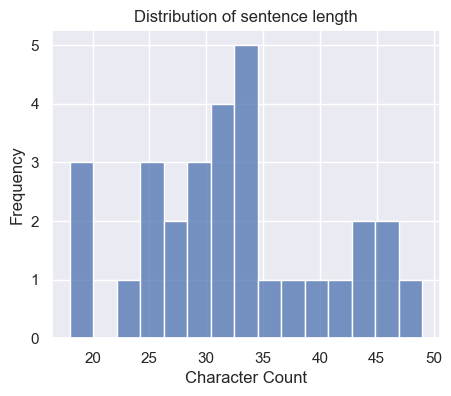

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# matpolitlib config
%matplotlib inline

# Style setup
plt.style.use('ggplot')
sns.set()

_=plt.figure(figsize=(5, 4))
_=sns.histplot(data=sentence_sim['char_count'].to_pandas(), bins=15)
_=plt.title('Distribution of sentence length')
_=plt.xlabel('Character Count')
_=plt.ylabel('Frequency')
_=plt.grid(True)
plt.show()

### Visualize the new char sized

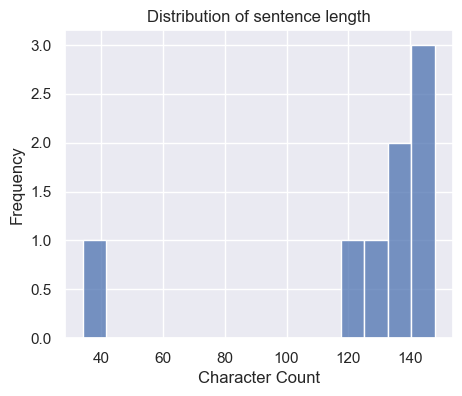

In [16]:
_=plt.figure(figsize=(5, 4))
_=sns.histplot(data=chunks['char_count'].to_pandas(), bins=15)
_=plt.title('Distribution of sentence length')
_=plt.xlabel('Character Count')
_=plt.ylabel('Frequency')
_=plt.grid(True)
plt.show()